In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scipy import stats

In [23]:
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    print(f"Shape data awal: {df.shape}")
    print(f"Kolom data: {df.columns.tolist()}")
    print(df.head())

    if 'created_at' not in df.columns:
        raise ValueError("Kolom 'created_at' tidak ditemukan dalam dataset.")

    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df = df.dropna(subset=['created_at'])
    df = df.sort_values('created_at').reset_index(drop=True)

    print(f"Rentang waktu: {df['created_at'].min()} sampai {df['created_at'].max()}")
    return df

In [24]:
file_path = "datas2.csv"

In [25]:
def get_scaler(scaler_type='standard'):
    if scaler_type == 'standard':
        return StandardScaler()
    elif scaler_type == 'minmax':
        return MinMaxScaler()
    elif scaler_type == 'robust':
        return RobustScaler()

In [26]:
def handle_missing_values(df):

    print("\n=== Analisis Missing Values ===")
    missing_info = df.isnull().sum()
    print(missing_info[missing_info > 0])
    
    # Untuk kolom numerik, gunakan interpolasi atau median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            # Gunakan interpolasi linear untuk time series
            df[col] = df[col].interpolate(method='linear')
            # Isi sisa dengan median
            df[col] = df[col].fillna(df[col].median())
    
    return df

In [27]:
def tampilkan_distribusi_chart(df):
    numeric_cols = df.select_dtypes(include='number').columns
    total_cols = len(numeric_cols)
    
    plt.figure(figsize=(15, 5 * total_cols))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(total_cols, 2, 2 * i - 1)
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Histogram: {col}')

        plt.subplot(total_cols, 2, 2 * i)
        sns.boxplot(x=df[col], color='salmon')
        plt.title(f'Boxplot: {col}')

    plt.tight_layout()
    plt.show()

In [28]:
def detect_and_handle_outliers(df, skew_threshold=0.5, zscore_threshold=3, remove=True, verbose=True):
    
    if verbose:
        print("\n=== Deteksi Outliers dengan Metode Adaptif ===")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outlier_info = {}
    method_used = {}
    outlier_mask = pd.Series(False, index=df.index)
    
    for col in numeric_cols:
        # Hitung skewness untuk menentukan metode
        col_skew = abs(df[col].skew())
        
        if col_skew > skew_threshold:
            # Data skewed -> gunakan IQR
            method = 'IQR'
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            col_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        else:
            # Data normal -> gunakan Z-Score
            method = 'Z-Score'
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            col_mask = z_scores > zscore_threshold
        
        outliers_count = col_mask.sum()
        outlier_info[col] = outliers_count
        method_used[col] = method
        outlier_mask = outlier_mask | col_mask
        
        if verbose:
            print(f"{col}: {outliers_count} outliers (Skew: {col_skew:.3f}, Method: {method})")
    
    # Handle outliers
    if remove and outlier_mask.sum() > 0:
        df_clean = df[~outlier_mask].copy()
        if verbose:
            print(f"\nMenghapus {outlier_mask.sum()} baris yang mengandung outliers.")
            print(f"Dataset size: {len(df)} → {len(df_clean)} (berkurang {len(df) - len(df_clean)} baris)")
    else:
        df_clean = df.copy()
        if verbose and not remove:
            print(f"\nOutliers tidak dihapus. Total baris dengan outliers: {outlier_mask.sum()}")
    
    return df_clean, outlier_info, method_used


In [29]:
def test_normality_detailed(df, alpha=0.05):

    print("\n=== Test Normalitas Detail ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    normality_results = {}
    
    for col in numeric_cols:
        # Shapiro-Wilk test (untuk sampel kecil)
        if len(df[col]) <= 5000:
            stat, p_value = stats.shapiro(df[col].dropna())
            test_name = "Shapiro-Wilk"
        else:
            # Kolmogorov-Smirnov test (untuk sampel besar)
            stat, p_value = stats.kstest(df[col].dropna(), 'norm')
            test_name = "Kolmogorov-Smirnov"
        
        is_normal = p_value > alpha
        skewness = df[col].skew()
        kurtosis = df[col].kurtosis()
        
        normality_results[col] = {
            'test': test_name,
            'statistic': stat,
            'p_value': p_value,
            'is_normal': is_normal,
            'skewness': skewness,
            'kurtosis': kurtosis
        }
        
        print(f"{col}:")
        print(f"  {test_name}: p-value = {p_value:.4f} ({'Normal' if is_normal else 'Tidak Normal'})")
        print(f"  Skewness: {skewness:.3f}, Kurtosis: {kurtosis:.3f}")
    
    return normality_results

In [30]:
def feature_engineering(df):
    print("\n=== Feature Engineering ===")
    
    df['hour'] = df['created_at'].dt.hour
    df['day_of_week'] = df['created_at'].dt.dayofweek
    df['day_of_month'] = df['created_at'].dt.day
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['hour', 'day_of_week', 'day_of_month']]
    
    window_sizes = [3, 5, 10]
    for window in window_sizes:
        for col in numeric_cols[:3]:  
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()

    df = df.dropna().reset_index(drop=True)
    
    print(f"Shape setelah feature engineering: {df.shape}")
    return df

In [31]:
def normalize_features(df, scaler, fit=True, feature_columns=None):
    print("\n=== Normalisasi ===")
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if fit:
        scaled = scaler.fit_transform(df[cols])
        feature_columns = cols
    else:
        scaled = scaler.transform(df[feature_columns])
    
    df_scaled = df.copy()
    df_scaled[feature_columns] = scaled
    return df_scaled, feature_columns

In [32]:
def create_sequences(df, sequence_length=5, target_cols=None):
    print(f"\n=== Membuat Sequences (length={sequence_length}) ===")
    if target_cols is None:
        target_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    sequences = []
    timestamps = []
    for i in range(len(df) - sequence_length + 1):
        seq = df[target_cols].iloc[i:i+sequence_length].values
        sequences.append(seq)
        timestamps.append(df['created_at'].iloc[i+sequence_length-1])
    
    sequences = np.array(sequences)
    print(f"Shape sequences: {sequences.shape}")
    print(f"Jumlah sequences: {len(sequences)}")
    return sequences, timestamps

In [33]:
def split_data(sequences, timestamps, train_ratio=0.8):
    split = int(len(sequences) * train_ratio)
    X_train = sequences[:split]
    X_test = sequences[split:]
    train_timestamps = timestamps[:split]
    test_timestamps = timestamps[split:]
    print(f"\n=== Data Split ===")
    print(f"Training sequences: {X_train.shape}")
    print(f"Testing sequences: {X_test.shape}")
    return X_train, X_test, train_timestamps, test_timestamps

In [34]:
def plot_data_overview(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns[:10]
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            axes[i].plot(df['created_at'], df[col])
            axes[i].set_title(f'{col} over time')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 10))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.show()

In [35]:
def main_preprocessing(file_path, sequence_length=10, scaler_type='robust'):
    scaler = get_scaler(scaler_type)
    df = load_and_clean_data(file_path)
    df = handle_missing_values(df)
    normality_results = test_normality_detailed(df)
    df_clean, outlier_info, methods = detect_and_handle_outliers(
        df, 
        skew_threshold=0.5,
        zscore_threshold=3,
        remove=True,
        verbose=True
    )
    normality_results_2 = test_normality_detailed(df_clean)
    # df = feature_engineering(df)
    plot_data_overview(df_clean)
    df_scaled, feature_columns = normalize_features(df, scaler, fit=True)
    sequences, timestamps = create_sequences(df_scaled, sequence_length, target_cols=feature_columns)
    
    X_train, X_test, train_timestamps, test_timestamps = split_data(sequences, timestamps)
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'train_timestamps': train_timestamps,
        'test_timestamps': test_timestamps,
        'feature_columns': feature_columns,
        'original_df': df,
        'scaled_df': df_scaled
    }

Shape data awal: (8800, 11)
Kolom data: ['fw_load_avg_1_min', 'fw_load_avg_5_min', 'fw_load_avg_15_min', 'fw_cpu_used', 'mem_used', 'root_used', 'log_used', 'fw_total_alloc', 'total_rx_packets', 'total_tx_packets', 'created_at']
   fw_load_avg_1_min  fw_load_avg_5_min  fw_load_avg_15_min  fw_cpu_used  \
0               0.20               0.15                0.17            0   
1               0.22               0.24                0.23            0   
2               0.30               0.25                0.21            1   
3               0.24               0.23                0.21            1   
4               0.10               0.21                0.20            0   

   mem_used  root_used  log_used  fw_total_alloc  total_rx_packets  \
0   7917172   10093296  10308548       648786522          19141339   
1   7913424   10093272  10308720       648678277          19132895   
2   7913156   10093292  10308316       648648252          19131269   
3   7922540   10093292  10308316  

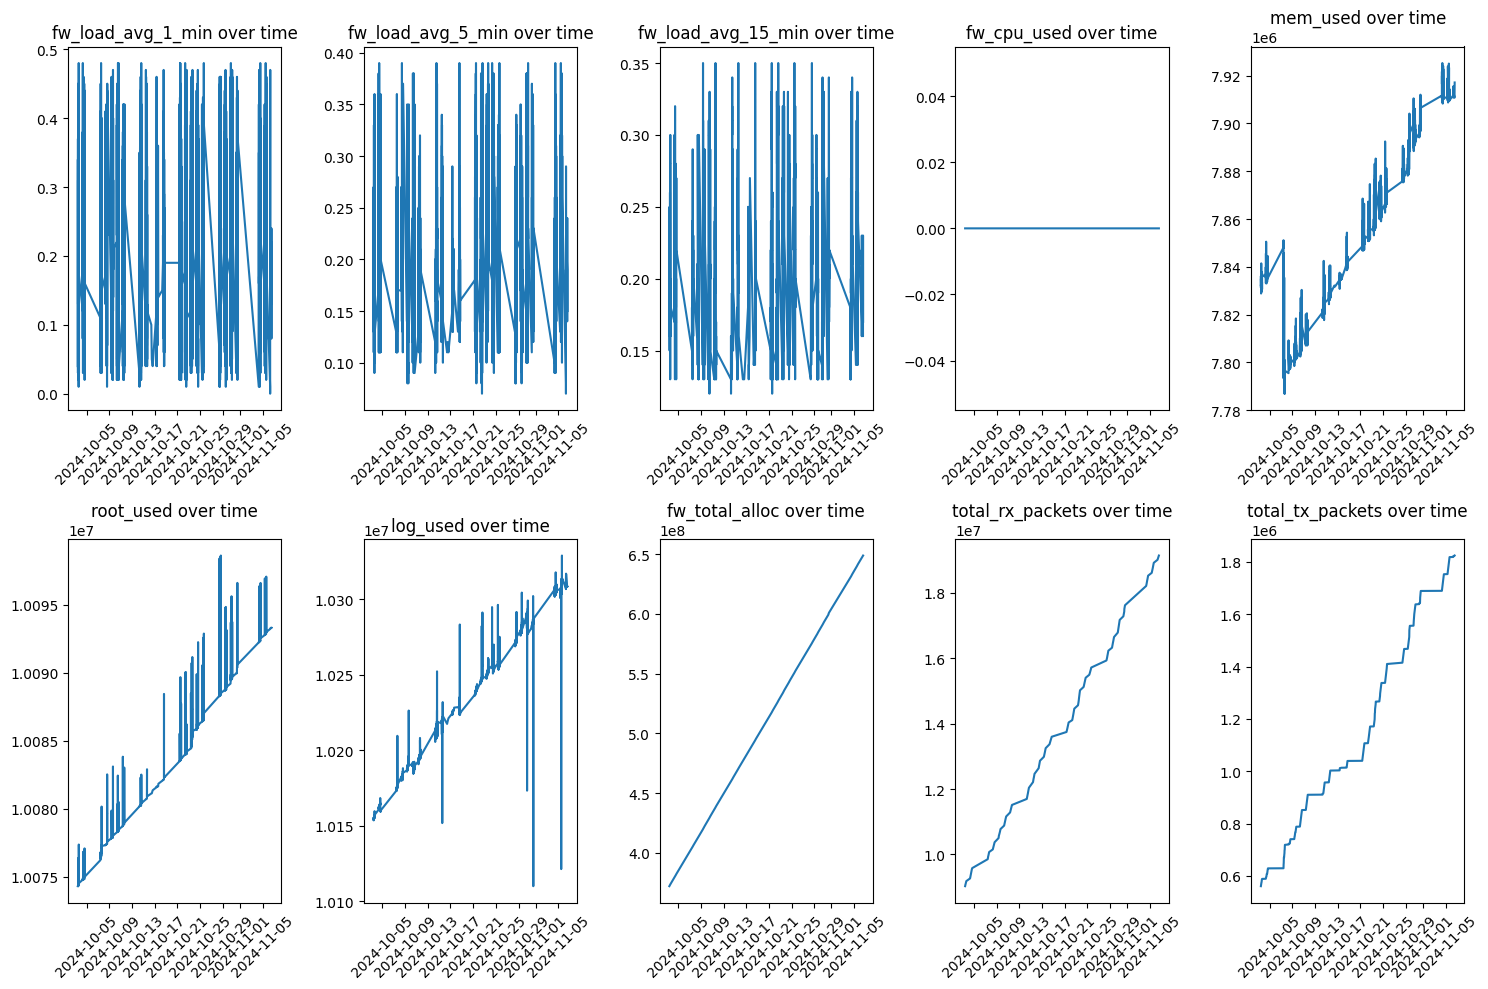

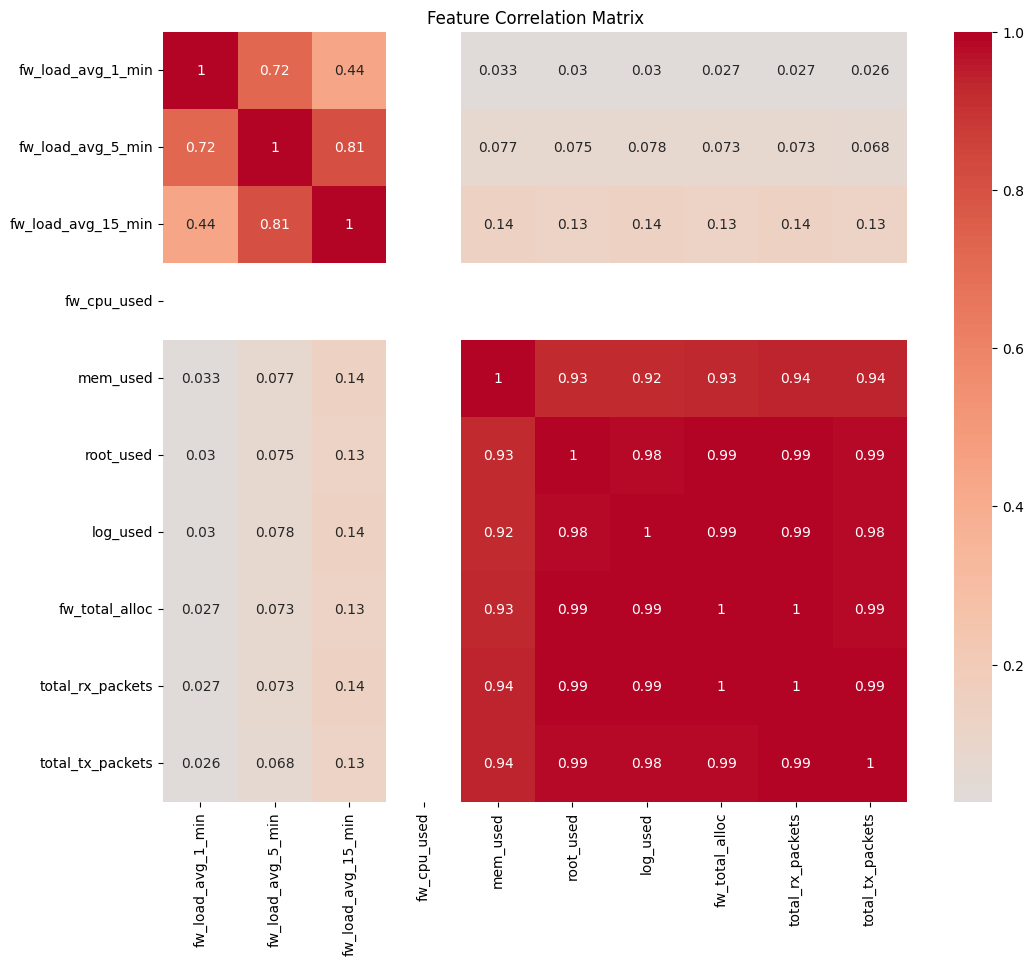


=== Normalisasi ===

=== Membuat Sequences (length=10) ===
Shape sequences: (8791, 10, 10)
Jumlah sequences: 8791

=== Data Split ===
Training sequences: (7032, 10, 10)
Testing sequences: (1759, 10, 10)


In [36]:
results = main_preprocessing(file_path)

----------------------------------------------------------------------------------------------------------------

In [37]:
def build_lstm_autoencoder(timesteps, n_features, latent_dim=32):
    inputs = Input(shape=(timesteps, n_features))
    
    encoded = LSTM(64, activation='tanh', dropout=0.2, recurrent_dropout=0.2,
                   kernel_regularizer=l2(0.001), return_sequences=True)(inputs)
    encoded = LSTM(latent_dim, activation='tanh', dropout=0.2, recurrent_dropout=0.2,
                   kernel_regularizer=l2(0.001))(encoded)
    
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(64, activation='tanh', dropout=0.2, recurrent_dropout=0.2,
                   return_sequences=True)(decoded)
    decoded = LSTM(n_features, activation='tanh', return_sequences=True,
                   dropout=0.2)(decoded)
    
    outputs = TimeDistributed(Dense(n_features, activation='linear'))(decoded)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mse'])
    
    return model

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_advanced_visualizations_mse(history, train_mse, test_mse, train_repr, test_repr,
                                      thresholds, X_train, X_train_pred, X_test, X_test_pred,
                                      y_train=None, y_test=None):
    """
    Create comprehensive visualizations for autoencoder anomaly detection using MSE
    
    Parameters:
    -----------
    history : keras.callbacks.History
        Training history object
    train_mse : array
        MSE values for training set
    test_mse : array  
        MSE values for test set
    train_repr : array
        Latent representations for training set
    test_repr : array
        Latent representations for test set
    thresholds : dict
        Dictionary containing threshold values (mse_percentile, mse_mean_std, mse_iqr)
    X_train : array
        Original training data
    X_train_pred : array
        Reconstructed training data
    X_test : array
        Original test data
    X_test_pred : array
        Reconstructed test data
    y_train : array, optional
        Training labels (0=normal, 1=anomaly)
    y_test : array, optional
        Test labels (0=normal, 1=anomaly)
    """
    
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training History
    plt.subplot(3, 4, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs Validation Loss', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Reconstruction Error Distribution (MSE)
    plt.subplot(3, 4, 2)
    plt.hist(train_mse, bins=50, alpha=0.7, label='Train MSE', density=True, color='blue')
    plt.hist(test_mse, bins=50, alpha=0.7, label='Test MSE', density=True, color='orange')
    
    # Plot thresholds
    colors = ['red', 'green', 'purple']
    threshold_names = ['mse_percentile', 'mse_mean_std', 'mse_iqr']
    for i, name in enumerate(threshold_names):
        if name in thresholds:
            plt.axvline(thresholds[name], color=colors[i], linestyle='--', 
                       label=f'{name}: {thresholds[name]:.6f}')
    
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.title('MSE Distribution with Thresholds', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 3. Box Plot of MSE Errors
    plt.subplot(3, 4, 3)
    data_to_plot = [train_mse, test_mse]
    labels = ['Train', 'Test']
    colors_box = ['lightblue', 'lightcoral']
    
    if y_train is not None and y_test is not None:
        # Separate normal and anomaly if labels available
        normal_train = train_mse[y_train == 0] if len(y_train) > 0 else train_mse
        normal_test = test_mse[y_test == 0] if len(y_test) > 0 else test_mse
        anomaly_test = test_mse[y_test == 1] if len(y_test) > 0 and np.any(y_test == 1) else []
        
        data_to_plot = [normal_train, normal_test]
        labels = ['Train Normal', 'Test Normal']
        colors_box = ['lightblue', 'lightgreen', 'lightcoral']
        if len(anomaly_test) > 0:
            data_to_plot.append(anomaly_test)
            labels.append('Test Anomaly')
    
    box_plot = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch, color in zip(box_plot['boxes'], colors_box):
        patch.set_facecolor(color)
        
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('MSE Distribution Comparison', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better MSE visualization
    
    # 4. Representations Scatter Plot (2D projection)
    plt.subplot(3, 4, 4)
    try:
        # Handle different representation shapes
        if train_repr.ndim > 2:
            train_repr_2d = train_repr.reshape(train_repr.shape[0], -1)
            test_repr_2d = test_repr.reshape(test_repr.shape[0], -1)
        else:
            train_repr_2d = train_repr
            test_repr_2d = test_repr
            
        if train_repr_2d.shape[1] >= 2:
            plt.scatter(train_repr_2d[:, 0], train_repr_2d[:, 1], alpha=0.6, s=20, 
                       label='Train', c='blue')
            plt.scatter(test_repr_2d[:, 0], test_repr_2d[:, 1], alpha=0.6, s=20, 
                       label='Test', c='orange')
            plt.xlabel('Latent Dimension 1')
            plt.ylabel('Latent Dimension 2')
        elif train_repr_2d.shape[1] == 1:
            # 1D representation
            plt.scatter(range(len(train_repr_2d)), train_repr_2d[:, 0], alpha=0.6, s=20, 
                       label='Train', c='blue')
            plt.scatter(range(len(test_repr_2d)), test_repr_2d[:, 0], alpha=0.6, s=20, 
                       label='Test', c='orange')
            plt.xlabel('Sample Index')
            plt.ylabel('Latent Value')
        else:
            plt.text(0.5, 0.5, 'Representation\nvisualization\nnot available', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.title('Latent Space Representations', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Warning: Could not create representation scatter plot: {e}")
        plt.text(0.5, 0.5, f'Representation plot\nnot available\n({e})', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Latent Space Representations', fontweight='bold')
    
    # 5. Reconstruction Quality Samples
    plt.subplot(3, 4, 5)
    n_samples = min(5, X_test.shape[0])
    sample_indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        if X_test.ndim == 3:  # Time series data
            plt.plot(X_test[idx, :, 0], alpha=0.7, 
                    label=f'Original {i+1}' if i < 2 else "", color=f'C{i}')
            plt.plot(X_test_pred[idx, :, 0], '--', alpha=0.7, 
                    label=f'Reconstructed {i+1}' if i < 2 else "", color=f'C{i}')
        else:  # 2D data
            plt.plot(X_test[idx, :], alpha=0.7, 
                    label=f'Original {i+1}' if i < 2 else "", color=f'C{i}')
            plt.plot(X_test_pred[idx, :], '--', alpha=0.7, 
                    label=f'Reconstructed {i+1}' if i < 2 else "", color=f'C{i}')
    
    plt.xlabel('Feature/Time Steps')
    plt.ylabel('Value')
    plt.title('Original vs Reconstructed Samples', fontweight='bold')
    if n_samples <= 2:
        plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. MSE Time Series
    plt.subplot(3, 4, 6)
    plt.plot(test_mse, alpha=0.8, linewidth=1, color='orange')
    plt.axhline(thresholds.get('mse_percentile', np.percentile(test_mse, 95)), 
                color='red', linestyle='--', 
                label=f'Threshold: {thresholds.get("mse_percentile", np.percentile(test_mse, 95)):.6f}')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('Test MSE Time Series', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better MSE visualization
    
    # 7. Latent Space Analysis
    plt.subplot(3, 4, 7)
    try:
        if train_repr.ndim > 2:
            train_repr_flat = train_repr.reshape(train_repr.shape[0], -1)
        else:
            train_repr_flat = train_repr
            
        if train_repr_flat.shape[1] > 1 and train_repr_flat.shape[1] <= 50:
            # Show correlation matrix of latent dimensions
            corr_matrix = np.corrcoef(train_repr_flat.T)
            if not np.isnan(corr_matrix).all():
                sns.heatmap(corr_matrix, annot=True if train_repr_flat.shape[1] <= 10 else False, 
                           cmap='coolwarm', center=0, square=True, 
                           cbar_kws={'label': 'Correlation'})
                plt.title('Latent Dimensions Correlation', fontweight='bold')
            else:
                plt.hist(train_repr_flat.flatten(), bins=30, alpha=0.7, color='skyblue')
                plt.xlabel('Latent Value')
                plt.ylabel('Frequency')
                plt.title('Latent Space Distribution', fontweight='bold')
                plt.grid(True, alpha=0.3)
        else:
            plt.hist(train_repr_flat.flatten(), bins=30, alpha=0.7, color='skyblue')
            plt.xlabel('Latent Value')
            plt.ylabel('Frequency')
            plt.title('Latent Space Distribution', fontweight='bold')
            plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Warning: Could not create latent space visualization: {e}")
        plt.text(0.5, 0.5, f'Latent visualization\nnot available\n({e})', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Latent Space Analysis', fontweight='bold')
    
    # 8. Feature-wise MSE
    plt.subplot(3, 4, 8)
    if X_test.ndim == 3:  # Time series data
        feature_errors = np.mean((X_test - X_test_pred)**2, axis=(0, 1))
    else:  # 2D data
        feature_errors = np.mean((X_test - X_test_pred)**2, axis=0)
        
    plt.bar(range(len(feature_errors)), feature_errors, color='lightcoral')
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Squared Error')
    plt.title('Feature-wise Reconstruction MSE', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better MSE visualization
    
    # 9. MSE vs Sample Index with Anomaly Highlighting
    plt.subplot(3, 4, 9)
    if y_test is not None:
        normal_indices = np.where(y_test == 0)[0]
        anomaly_indices = np.where(y_test == 1)[0]
        
        plt.scatter(normal_indices, test_mse[normal_indices], alpha=0.6, 
                   c='blue', s=20, label='Normal')
        if len(anomaly_indices) > 0:
            plt.scatter(anomaly_indices, test_mse[anomaly_indices], alpha=0.8, 
                       c='red', s=30, label='Anomaly')
        plt.axhline(thresholds.get('mse_percentile', np.percentile(test_mse, 95)), 
                    color='red', linestyle='--', alpha=0.7, label='Threshold')
    else:
        plt.scatter(range(len(test_mse)), test_mse, alpha=0.6, c='orange', s=20)
        plt.axhline(thresholds.get('mse_percentile', np.percentile(test_mse, 95)), 
                    color='red', linestyle='--', alpha=0.7, label='Threshold')
    
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction MSE')
    plt.title('MSE Distribution by Sample', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # 10. Normal vs Anomaly MSE Distribution
    if y_test is not None and np.any(y_test == 1):
        plt.subplot(3, 4, 10)
        normal_errors = test_mse[y_test == 0]
        anomaly_errors = test_mse[y_test == 1]
        
        plt.hist(normal_errors, bins=30, alpha=0.7, label='Normal', 
                density=True, color='blue')
        plt.hist(anomaly_errors, bins=30, alpha=0.7, label='Anomaly', 
                density=True, color='red')
        plt.axvline(thresholds.get('mse_percentile', np.percentile(test_mse, 95)), 
                    color='green', linestyle='--', label='Threshold')
        plt.xlabel('Reconstruction MSE')
        plt.ylabel('Density')
        plt.title('Normal vs Anomaly MSE Distribution', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xscale('log')
    
    # 11. MSE Statistics Summary
    plt.subplot(3, 4, 11)
    stats_text = f"""MSE Statistics:
    
Train MSE:
Mean: {np.mean(train_mse):.6f}
Std: {np.std(train_mse):.6f}
Min: {np.min(train_mse):.6f}
Max: {np.max(train_mse):.6f}

Test MSE:
Mean: {np.mean(test_mse):.6f}
Std: {np.std(test_mse):.6f}
Min: {np.min(test_mse):.6f}
Max: {np.max(test_mse):.6f}

Thresholds:"""
    
    for name, value in thresholds.items():
        stats_text += f"\n{name}: {value:.6f}"
    
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
             fontsize=9, verticalalignment='top', fontfamily='monospace')
    plt.axis('off')
    plt.title('MSE Statistics Summary', fontweight='bold')
    
    # 12. Reconstruction Error Heatmap
    plt.subplot(3, 4, 12)
    try:
        if X_test.ndim == 3:  # Time series
            # Show error heatmap for first few samples
            n_samples_heatmap = min(20, X_test.shape[0])
            error_matrix = (X_test[:n_samples_heatmap, :, 0] - 
                           X_test_pred[:n_samples_heatmap, :, 0])**2
        else:  # 2D data
            n_samples_heatmap = min(20, X_test.shape[0])
            error_matrix = (X_test[:n_samples_heatmap, :] - 
                           X_test_pred[:n_samples_heatmap, :])**2
        
        sns.heatmap(error_matrix, cmap='Reds', cbar_kws={'label': 'Squared Error'})
        plt.xlabel('Feature/Time Index')
        plt.ylabel('Sample Index')
        plt.title('Reconstruction Error Heatmap', fontweight='bold')
    except Exception as e:
        print(f"Warning: Could not create error heatmap: {e}")
        plt.text(0.5, 0.5, f'Error heatmap\nnot available\n({e})', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Reconstruction Error Heatmap', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Helper function to calculate MSE-based thresholds
def calculate_mse_thresholds(train_mse, test_mse=None, percentile=95):
    thresholds = {}
    
    # Use training MSE for threshold calculation
    mse_data = train_mse
    
    # Percentile-based threshold
    thresholds['mse_percentile'] = np.percentile(mse_data, percentile)
    
    # Mean + std threshold
    mean_mse = np.mean(mse_data)
    std_mse = np.std(mse_data)
    thresholds['mse_mean_std'] = mean_mse + 2 * std_mse
    
    # IQR-based threshold
    Q1 = np.percentile(mse_data, 25)
    Q3 = np.percentile(mse_data, 75)
    IQR = Q3 - Q1
    thresholds['mse_iqr'] = Q3 + 1.5 * IQR
    
    return thresholds

In [39]:
def evaluate_anomaly_detection_mse(train_mse, test_mse, y_train, y_test, thresholds):

    from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score, 
                                accuracy_score, confusion_matrix, classification_report)
    
    results = {}
    
    print("🔍 Evaluating MSE-based Anomaly Detection Performance")
    print("=" * 60)
    
    for threshold_name, threshold_value in thresholds.items():
        if 'mse' in threshold_name:
            # Make predictions based on MSE threshold
            predictions = (test_mse > threshold_value).astype(int)
            
            try:
                # Calculate basic metrics
                precision, recall, f1, _ = precision_recall_fscore_support(
                    y_test, predictions, average='binary', zero_division=0
                )
                
                # Calculate additional metrics
                accuracy = accuracy_score(y_test, predictions)
                auc_score = roc_auc_score(y_test, test_mse)
                
                # Confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
                
                # Calculate specificity (True Negative Rate)
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                
                # Calculate False Positive Rate
                fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                
                # Calculate False Negative Rate
                fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
                
                # Store results
                results[threshold_name] = {
                    'threshold': threshold_value,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'accuracy': accuracy,
                    'auc': auc_score,
                    'specificity': specificity,
                    'fpr': fpr,
                    'fnr': fnr,
                    'true_positives': tp,
                    'true_negatives': tn,
                    'false_positives': fp,
                    'false_negatives': fn,
                    'predictions': predictions,
                    'confusion_matrix': [[tn, fp], [fn, tp]]
                }
                
                # Print detailed results
                print(f"\n📈 Performance with {threshold_name}:")
                print(f"  📊 Threshold Value: {threshold_value:.8f}")
                print(f"  🎯 Accuracy: {accuracy:.4f}")
                print(f"  🔍 Precision: {precision:.4f}")
                print(f"  📡 Recall (Sensitivity): {recall:.4f}")
                print(f"  ⚖️  F1-Score: {f1:.4f}")
                print(f"  📈 AUC-ROC: {auc_score:.4f}")
                print(f"  🛡️  Specificity: {specificity:.4f}")
                print(f"  ⚠️  False Positive Rate: {fpr:.4f}")
                print(f"  ❌ False Negative Rate: {fnr:.4f}")
                print(f"  📋 Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
                
                # Interpretation
                if f1 > 0.8:
                    print(f"  ✅ Excellent performance!")
                elif f1 > 0.6:
                    print(f"  ✨ Good performance!")
                elif f1 > 0.4:
                    print(f"  ⚡ Moderate performance")
                else:
                    print(f"  ⚠️  Performance needs improvement")
                
            except Exception as e:
                print(f"❌ Error evaluating {threshold_name}: {e}")
                results[threshold_name] = {
                    'threshold': threshold_value,
                    'error': str(e)
                }
    
    # Find best threshold
    if results:
        best_threshold = max(results.keys(), 
                           key=lambda x: results[x].get('f1', 0) if 'error' not in results[x] else 0)
        
        print(f"\n🏆 Best Threshold: {best_threshold}")
        if 'error' not in results[best_threshold]:
            best_result = results[best_threshold]
            print(f"   F1-Score: {best_result['f1']:.4f}")
            print(f"   Precision: {best_result['precision']:.4f}")
            print(f"   Recall: {best_result['recall']:.4f}")
            print(f"   AUC: {best_result['auc']:.4f}")
    
    return results


def detailed_mse_analysis(train_mse, test_mse, y_train, y_test, thresholds):
    """
    Perform detailed MSE analysis with statistical insights
    
    Parameters:
    -----------
    train_mse : array
        MSE values from training set
    test_mse : array
        MSE values from test set
    y_train : array
        Training labels
    y_test : array
        Test labels
    thresholds : dict
        MSE thresholds
        
    Returns:
    --------
    dict : Detailed analysis results
    """
    import numpy as np
    from scipy import stats
    
    print("\n🔬 Detailed MSE Statistical Analysis")
    print("=" * 50)
    
    analysis = {}
    
    # Basic statistics
    train_stats = {
        'mean': np.mean(train_mse),
        'std': np.std(train_mse),
        'min': np.min(train_mse),
        'max': np.max(train_mse),
        'median': np.median(train_mse),
        'q25': np.percentile(train_mse, 25),
        'q75': np.percentile(train_mse, 75),
        'skewness': stats.skew(train_mse),
        'kurtosis': stats.kurtosis(train_mse)
    }
    
    test_stats = {
        'mean': np.mean(test_mse),
        'std': np.std(test_mse),
        'min': np.min(test_mse),
        'max': np.max(test_mse),
        'median': np.median(test_mse),
        'q25': np.percentile(test_mse, 25),
        'q75': np.percentile(test_mse, 75),
        'skewness': stats.skew(test_mse),
        'kurtosis': stats.kurtosis(test_mse)
    }
    
    print(f"📊 Training MSE Statistics:")
    print(f"   Mean: {train_stats['mean']:.8f} ± {train_stats['std']:.8f}")
    print(f"   Range: [{train_stats['min']:.8f}, {train_stats['max']:.8f}]")
    print(f"   Median: {train_stats['median']:.8f}")
    print(f"   IQR: [{train_stats['q25']:.8f}, {train_stats['q75']:.8f}]")
    print(f"   Skewness: {train_stats['skewness']:.4f}")
    print(f"   Kurtosis: {train_stats['kurtosis']:.4f}")
    
    print(f"\n📊 Test MSE Statistics:")
    print(f"   Mean: {test_stats['mean']:.8f} ± {test_stats['std']:.8f}")
    print(f"   Range: [{test_stats['min']:.8f}, {test_stats['max']:.8f}]")
    print(f"   Median: {test_stats['median']:.8f}")
    print(f"   IQR: [{test_stats['q25']:.8f}, {test_stats['q75']:.8f}]")
    print(f"   Skewness: {test_stats['skewness']:.4f}")
    print(f"   Kurtosis: {test_stats['kurtosis']:.4f}")
    
    # Separate normal and anomaly MSE if labels available
    if y_test is not None and len(np.unique(y_test)) > 1:
        normal_mse = test_mse[y_test == 0]
        anomaly_mse = test_mse[y_test == 1]
        
        if len(anomaly_mse) > 0:
            normal_stats = {
                'mean': np.mean(normal_mse),
                'std': np.std(normal_mse),
                'median': np.median(normal_mse),
                'max': np.max(normal_mse)
            }
            
            anomaly_stats = {
                'mean': np.mean(anomaly_mse),
                'std': np.std(anomaly_mse),
                'median': np.median(anomaly_mse),
                'min': np.min(anomaly_mse)
            }
            
            print(f"\n🟢 Normal Samples MSE:")
            print(f"   Count: {len(normal_mse)}")
            print(f"   Mean: {normal_stats['mean']:.8f} ± {normal_stats['std']:.8f}")
            print(f"   Median: {normal_stats['median']:.8f}")
            print(f"   Max: {normal_stats['max']:.8f}")
            
            print(f"\n🔴 Anomaly Samples MSE:")
            print(f"   Count: {len(anomaly_mse)}")
            print(f"   Mean: {anomaly_stats['mean']:.8f} ± {anomaly_stats['std']:.8f}")
            print(f"   Median: {anomaly_stats['median']:.8f}")
            print(f"   Min: {anomaly_stats['min']:.8f}")
            
            # Statistical test
            try:
                t_stat, p_value = stats.ttest_ind(normal_mse, anomaly_mse)
                print(f"\n📈 T-test (Normal vs Anomaly):")
                print(f"   T-statistic: {t_stat:.4f}")
                print(f"   P-value: {p_value:.2e}")
                print(f"   Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
                
                analysis['statistical_test'] = {
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }
            except:
                print(f"   Could not perform statistical test")
            
            analysis['normal_stats'] = normal_stats
            analysis['anomaly_stats'] = anomaly_stats
    
    # Threshold analysis
    print(f"\n🎯 Threshold Analysis:")
    for name, value in thresholds.items():
        above_threshold = np.sum(test_mse > value)
        percentage = (above_threshold / len(test_mse)) * 100
        print(f"   {name}: {value:.8f}")
        print(f"      Samples above threshold: {above_threshold} ({percentage:.2f}%)")
    
    analysis['train_stats'] = train_stats
    analysis['test_stats'] = test_stats
    analysis['thresholds'] = thresholds
    
    return analysis


def compare_mse_thresholds(test_mse, y_test, thresholds):
    """
    Compare different MSE thresholds visually
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: MSE distribution with thresholds
    plt.subplot(1, 3, 1)
    plt.hist(test_mse, bins=50, alpha=0.7, density=True, color='skyblue')
    
    colors = ['red', 'green', 'purple', 'orange']
    for i, (name, value) in enumerate(thresholds.items()):
        if 'mse' in name:
            plt.axvline(value, color=colors[i % len(colors)], linestyle='--', 
                       label=f'{name}: {value:.6f}')
    
    plt.xlabel('MSE Values')
    plt.ylabel('Density')
    plt.title('MSE Distribution with Thresholds')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    
    # Plot 2: Normal vs Anomaly if labels available
    if y_test is not None and len(np.unique(y_test)) > 1:
        plt.subplot(1, 3, 2)
        normal_mse = test_mse[y_test == 0]
        anomaly_mse = test_mse[y_test == 1]
        
        plt.hist(normal_mse, bins=30, alpha=0.7, label='Normal', density=True, color='blue')
        if len(anomaly_mse) > 0:
            plt.hist(anomaly_mse, bins=30, alpha=0.7, label='Anomaly', density=True, color='red')
        
        plt.xlabel('MSE Values')
        plt.ylabel('Density')
        plt.title('Normal vs Anomaly MSE Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xscale('log')
    
    # Plot 3: MSE over samples
    plt.subplot(1, 3, 3)
    if y_test is not None:
        normal_indices = np.where(y_test == 0)[0]
        anomaly_indices = np.where(y_test == 1)[0]
        
        plt.scatter(normal_indices, test_mse[normal_indices], alpha=0.6, 
                   c='blue', s=20, label='Normal')
        if len(anomaly_indices) > 0:
            plt.scatter(anomaly_indices, test_mse[anomaly_indices], alpha=0.8, 
                       c='red', s=30, label='Anomaly')
    else:
        plt.scatter(range(len(test_mse)), test_mse, alpha=0.6, c='orange', s=20)
    
    # Add threshold line
    main_threshold = list(thresholds.values())[0]
    plt.axhline(main_threshold, color='red', linestyle='--', alpha=0.7, label='Threshold')
    
    plt.xlabel('Sample Index')
    plt.ylabel('MSE Values')
    plt.title('MSE by Sample Index')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

In [40]:
def train_advanced_lstm_autoencoder(X_train, X_test, y_train=None, y_test=None, 
                                  epochs=300, batch_size=32, patience=5, 
                                  threshold_percentile=95, verbose=1):   
    timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    
    print(f"Data shape: {X_train.shape}")
    print(f"Timesteps: {timesteps}, Features: {n_features}")
    
    # Build model (assuming build_lstm_autoencoder function exists)
    model = build_lstm_autoencoder(timesteps, n_features)
    
    # Advanced callbacks
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=patience, 
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=patience//2,
        min_lr=1e-7,
        verbose=1
    )
    
    # Training
    print("\n🚀 Starting training...")
    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test),
        callbacks=[early_stop, reduce_lr],
        shuffle=False,
        verbose=verbose
    )
    
    # Get encoder model for representations
    # Find the bottleneck/encoding layer (usually the middle layer with smallest dimension)
    encoder_output = None
    min_units = float('inf')
    
    for i, layer in enumerate(model.layers):
        # Look for Dense layers that could be the bottleneck
        if hasattr(layer, 'units'):
            if layer.units < min_units:
                min_units = layer.units
                encoder_output = layer.output
        # Also check for LSTM layers in the encoder part
        elif 'lstm' in layer.name.lower() and i < len(model.layers) // 2:
            encoder_output = layer.output
    
    # If no specific encoder found, use middle layer
    if encoder_output is None:
        middle_idx = len(model.layers) // 2
        encoder_output = model.layers[middle_idx].output
    
    # Create encoder model
    encoder = Model(inputs=model.input, outputs=encoder_output)
    
    # Get predictions and representations
    print("\n🔍 Generating predictions and representations...")
    X_train_pred = model.predict(X_train, verbose=0)
    X_test_pred = model.predict(X_test, verbose=0)
    
    # Get encoded representations
    train_representations = encoder.predict(X_train, verbose=0)
    test_representations = encoder.predict(X_test, verbose=0)
    
    # Flatten representations if they have more than 2 dimensions
    if len(train_representations.shape) > 2:
        train_representations = train_representations.reshape(train_representations.shape[0], -1)
        test_representations = test_representations.reshape(test_representations.shape[0], -1)
    
    print(f"Representation shape: {train_representations.shape}")
    
    # Calculate reconstruction errors - MSE as primary metric
    train_mse = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))
    test_mse = np.mean(np.square(X_test - X_test_pred), axis=(1, 2))
    
    # Keep MAE as secondary metric for comparison
    train_mae = np.mean(np.abs(X_train - X_train_pred), axis=(1, 2))
    test_mae = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2))
    
    # Automatic threshold calculation - MSE focused
    thresholds = {
        'mse_mean_std': np.mean(train_mse) + 2 * np.std(train_mse),
        'mse_percentile': np.percentile(train_mse, threshold_percentile),
        'mse_iqr': np.percentile(train_mse, 75) + 1.5 * (np.percentile(train_mse, 75) - np.percentile(train_mse, 25)),
        'mse_3sigma': np.mean(train_mse) + 3 * np.std(train_mse),
        # Keep MAE thresholds as secondary options
        'mae_percentile': np.percentile(train_mae, threshold_percentile),
        'mae_mean_std': np.mean(train_mae) + 2 * np.std(train_mae)
    }
    
    # Calculate metrics - MSE focused
    metrics = {
        'train_mse_mean': np.mean(train_mse),
        'train_mse_std': np.std(train_mse),
        'test_mse_mean': np.mean(test_mse),
        'test_mse_std': np.std(test_mse),
        'train_mae_mean': np.mean(train_mae),
        'train_mae_std': np.std(train_mae),
        'test_mae_mean': np.mean(test_mae),
        'test_mae_std': np.std(test_mae)
    }
    
    print(f"\n📊 Reconstruction Error Statistics:")
    print(f"Training MSE: {metrics['train_mse_mean']:.5f} ± {metrics['train_mse_std']:.5f}")
    print(f"Test MSE: {metrics['test_mse_mean']:.5f} ± {metrics['test_mse_std']:.5f}")
    print(f"Training MAE: {metrics['train_mae_mean']:.5f} ± {metrics['train_mae_std']:.5f}")
    print(f"Test MAE: {metrics['test_mae_mean']:.5f} ± {metrics['test_mae_std']:.5f}")
    
    print(f"\n🎯 Automatic Thresholds (MSE Primary):")
    for name, threshold in thresholds.items():
        print(f"{name}: {threshold:.5f}")
    
    # Visualization
    create_advanced_visualizations_mse(
        history, train_mse, test_mse, train_representations, test_representations,
        thresholds, X_train, X_train_pred, X_test, X_test_pred, y_train, y_test
    )
    
    # Anomaly detection if labels provided - using MSE as primary
    anomaly_results = {}
    if y_train is not None and y_test is not None:
        anomaly_results = evaluate_anomaly_detection_mse(
            train_mse, test_mse, y_train, y_test, thresholds
        )
    
    # Prepare results
    results = {
        'model': model,
        'encoder': encoder,
        'history': history,
        'thresholds': thresholds,
        'metrics': metrics,
        'train_errors': {'mse': train_mse, 'mae': train_mae},
        'test_errors': {'mse': test_mse, 'mae': test_mae},
        'representations': {
            'train': train_representations,
            'test': test_representations
        },
        'predictions': {
            'train': X_train_pred,
            'test': X_test_pred
        },
        'anomaly_results': anomaly_results
    }
    
    return results

In [41]:
def save_model_with_threshold(model, threshold, model_name='lstm_autoencoder'):
    """
    Simpan model + threshold anomaly detection
    """
    import pickle
    
    # Save model
    model.save(f'{model_name}.keras')
    
    # Save threshold
    with open(f'{model_name}_threshold.pkl', 'wb') as f:
        pickle.dump(threshold, f)
    
    print(f"✅ Model disimpan: {model_name}.keras")
    print(f"✅ Threshold disimpan: {model_name}_threshold.pkl")

Data shape: (7032, 10, 10)
Timesteps: 10, Features: 10

🚀 Starting training...
Epoch 1/300
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.8355 - mse: 0.7356 - val_loss: 0.8141 - val_mse: 0.7274 - learning_rate: 1.0000e-04
Epoch 2/300
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.7277 - mse: 0.6444 - val_loss: 0.7418 - val_mse: 0.6681 - learning_rate: 1.0000e-04
Epoch 3/300
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.6424 - mse: 0.5713 - val_loss: 0.6937 - val_mse: 0.6302 - learning_rate: 1.0000e-04
Epoch 4/300
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.5782 - mse: 0.5166 - val_loss: 0.6583 - val_mse: 0.6027 - learning_rate: 1.0000e-04
Epoch 5/300
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.5305 - mse: 0.4763 - val_loss: 0.6294 - val_mse: 0.5800 - learning_rate: 1.0000e-04
Epoch 6/300
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.4919 - mse: 0.4437 - val_loss: 0.6046 - val_mse: 0.5603 - learning_rate: 1.0000e-04
Epoch 7/300
220/220 ━━━━━━━━━━━━

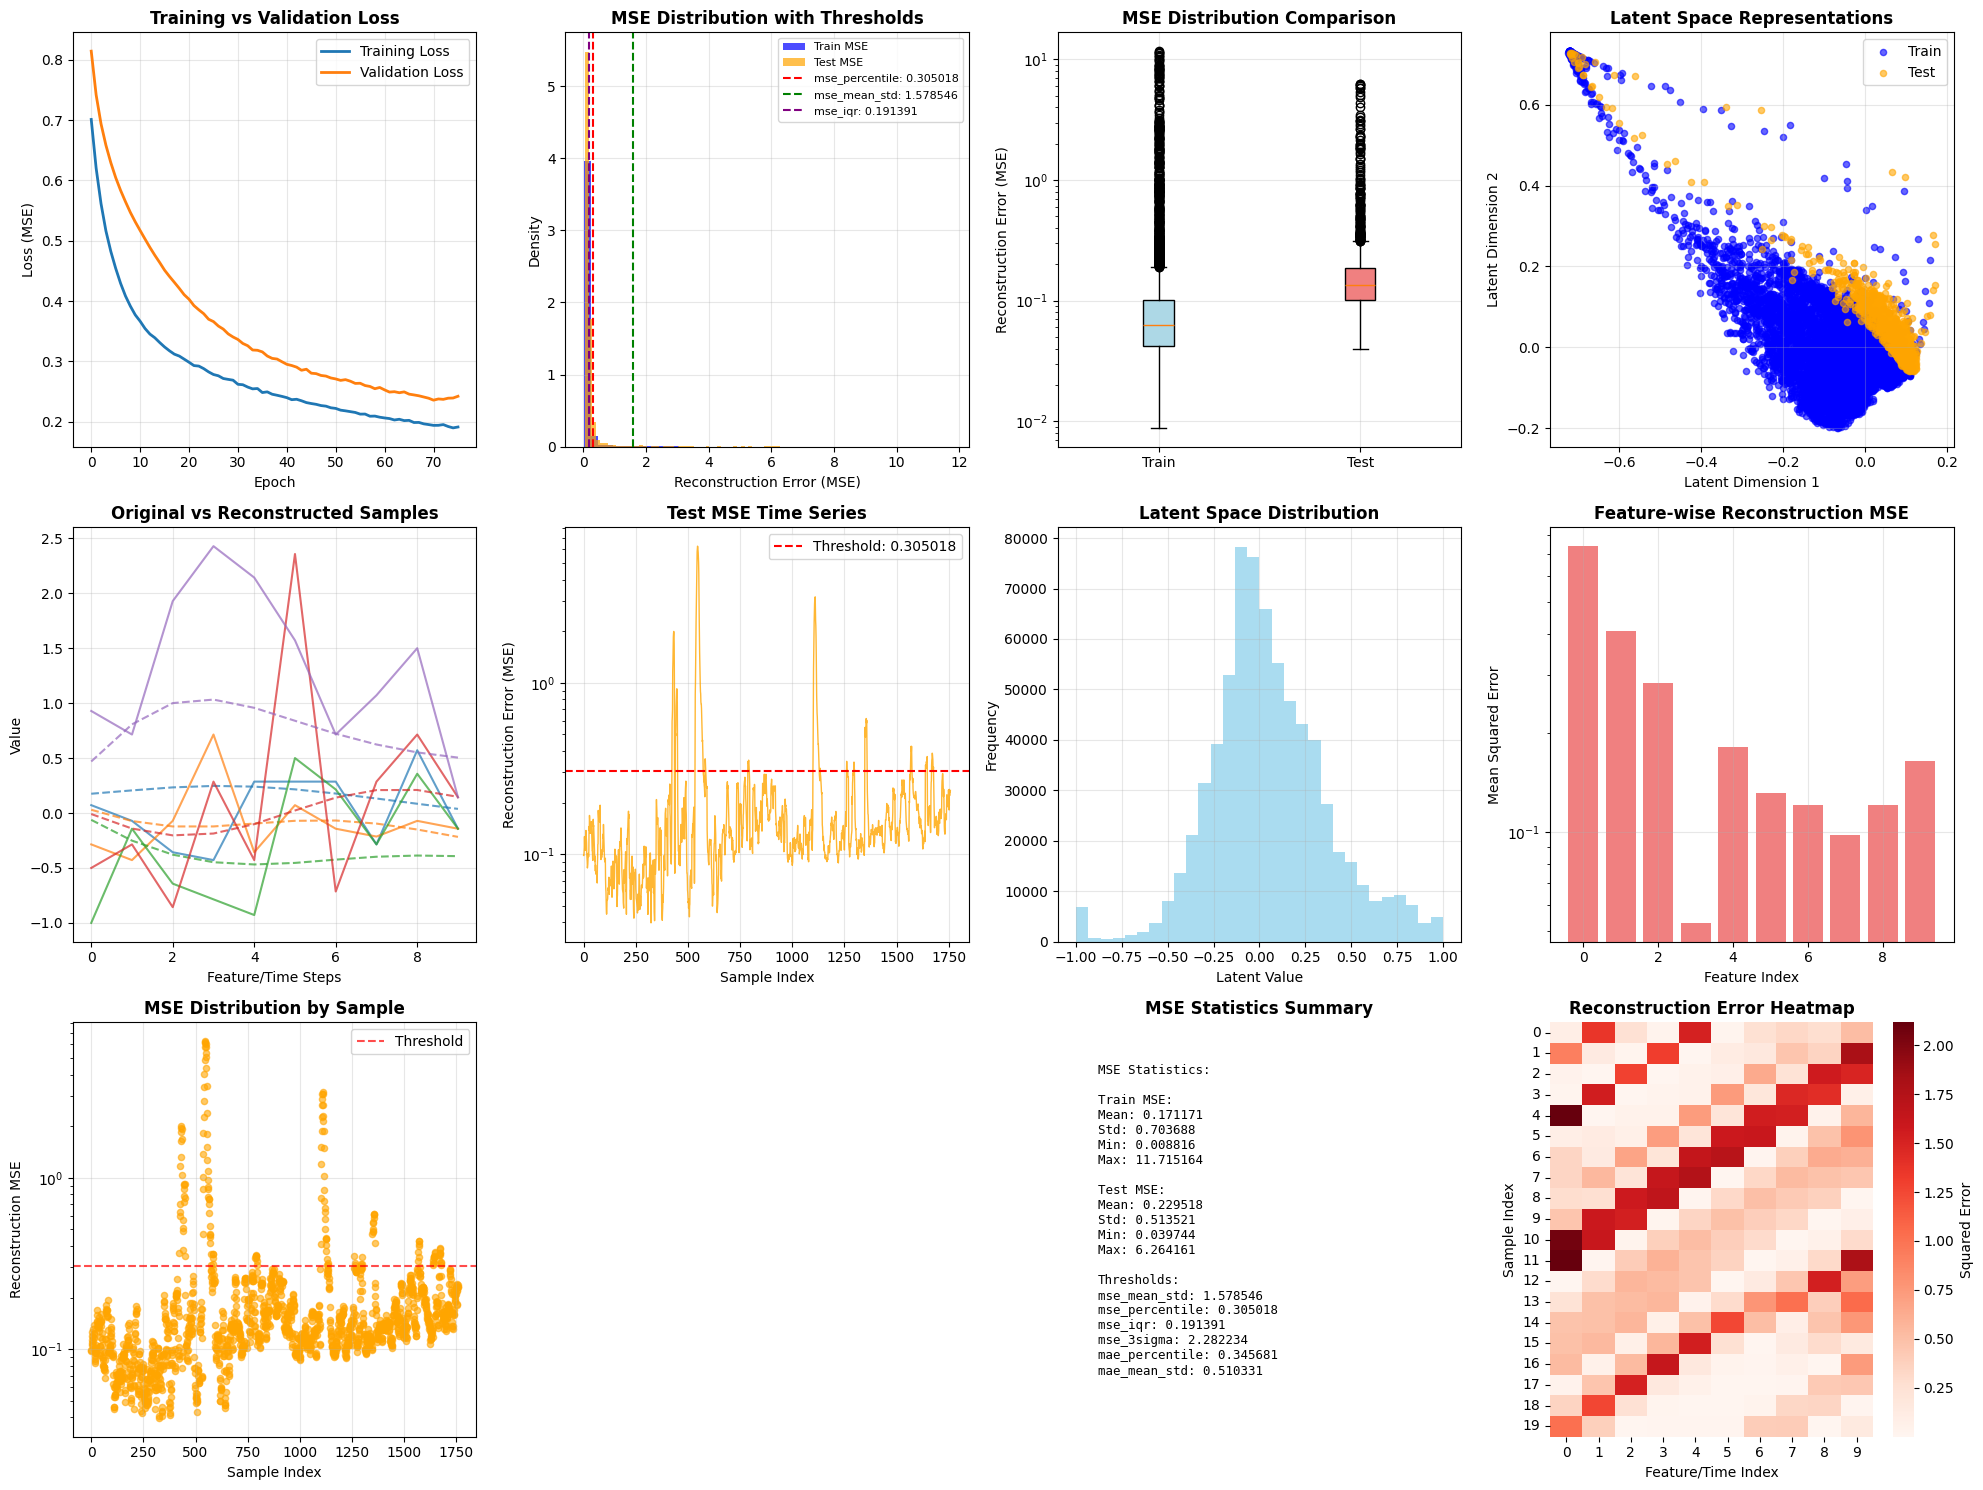

In [42]:
model_results = train_advanced_lstm_autoencoder(results['X_train'], results['X_test'])